In [309]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd.functional import jacobian

from PIL import Image
import os
import random
import numpy as np

import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directories to the path
""" sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader """

' sys.path.append("../models/")\nfrom CustomCNNVessel import CustomResNet\n\nsys.path.append("../data/")\nfrom VessMapDatasetLoader import vess_map_dataloader '

In [310]:
# Model definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    padding=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = nn.ReLU()(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.resblock1 = ResidualBlock(64, 128, stride=2)
        self.resblock2 = ResidualBlock(128, 256, stride=2)
        self.resblock3 = ResidualBlock(256, 512, stride=2)
        self.resblock4 = ResidualBlock(512, 1024, stride=2)

        self.dropout = nn.Dropout(0.5)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(
            1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.upconv2 = nn.ConvTranspose2d(
            512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.upconv3 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.upconv4 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        # Final Layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x2 = self.resblock1(x1)
        x3 = self.resblock2(x2)
        x4 = self.resblock3(x3)
        x5 = self.resblock4(x4)

        x5 = self.dropout(x5)

        # Decoder
        x = self.upconv1(x5)  # Upsampling
        x = crop_and_add(x, x4)
        x = self.upconv2(x)
        x = crop_and_add(x, x3)
        x = self.upconv3(x)
        x = crop_and_add(x, x2)
        x = self.upconv4(x)
        x = crop_and_add(x, x1)

        # Final Layer
        x = self.final(x)

        return x

    def forward_activation(self, x):
        self.activations = {}

        # Encoder
        x1 = self.conv1(x)
        self.activations["x1"] = x1
        x1_bn = self.bn1(x1)
        self.activations["x1_bn"] = x1_bn
        x1_relu = self.relu(x1_bn)
        self.activations["x1_relu"] = x1_relu

        x2 = self.resblock1(x1_relu)
        self.activations["x2"] = x2
        x3 = self.resblock2(x2)
        self.activations["x3"] = x3
        x4 = self.resblock3(x3)
        self.activations["x4"] = x4
        x5 = self.resblock4(x4)
        self.activations["x5"] = x5

        x5_drop = self.dropout(x5)
        self.activations["x5_drop"] = x5_drop

        # Decoder
        x = self.upconv1(x5_drop)  # Upsampling
        self.activations["upconv1"] = x

        x_1 = x + x4
        self.activations["skip1"] = x_1
        x_2 = self.upconv2(x_1)
        self.activations["upconv2"] = x_2

        x_3 = x_2 + x3
        self.activations["skip2"] = x_3
        x_4 = self.upconv3(x_3)
        self.activations["upconv3"] = x_4

        x_5 = x_4 + x2
        self.activations["skip3"] = x_5
        x_6 = self.upconv4(x_5)
        self.activations["upconv4"] = x_6

        x_7 = x_6 + x1
        self.activations["skip4"] = x_7

        # Final Layer
        x_final = self.final(x_7)
        self.activations["x_final"] = x_final

        return self.activations


def crop_and_add(x1, x2):
    """Crop x2 to the size of x1 and add them."""
    B, C, H, W = x2.size()
    x1 = x1[:B, :C, :H, :W]
    return x1 + x2


In [311]:
# Dataset definition
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, skeleton_dir, image_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.skeleton_dir = skeleton_dir
        self.image_size = image_size
        self.file_list = self._find_pairs(image_dir, mask_dir, skeleton_dir)
        self.transform = transforms.Compose([
            transforms.CenterCrop((image_size, image_size)),
            transforms.ToTensor(),
        ])

    def _find_pairs(self, image_dir, mask_dir, skeleton_dir):
        pairs = []
        for img_file in os.listdir(image_dir):
            base_name = os.path.splitext(img_file)[0]
            mask_file = os.path.join(mask_dir, base_name + ".png")
            skeleton_file = os.path.join(skeleton_dir, base_name + ".png")
            if os.path.exists(mask_file) and os.path.exists(skeleton_file):
                pairs.append(img_file)
        return pairs

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        image_path = os.path.join(self.image_dir, file_name)
        base_name = os.path.splitext(file_name)[0]
        mask_path = os.path.join(self.mask_dir, base_name + ".png")
        skeleton_path = os.path.join(self.skeleton_dir, base_name + ".png")

        image = Image.open(image_path)
        mask = Image.open(mask_path)
        skeleton = Image.open(skeleton_path)

        seed = 42
        random.seed(seed)  # Ensure same transformations
        image, mask, skeleton = [
            self.transform(x) for x in [image, mask, skeleton]
        ]
        
        return image, mask, skeleton
    
    def plot_samples(self):
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        sample_indices = random.sample(range(len(self)), 3)  # Pick 3 random indices
        
        for i, idx in enumerate(sample_indices):
            image, mask, skeleton = self.__getitem__(idx)
            
            # Convert tensors to numpy for plotting
            image_np = image.squeeze().numpy()
            mask_np = mask.squeeze().numpy()
            skeleton_np = skeleton.squeeze().numpy()
            
            # Plotting each column (image, mask, skeleton)
            axes[i, 0].imshow(image_np, cmap='gray')
            axes[i, 0].set_title(f'Image {idx}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title(f'Mask {idx}')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(skeleton_np, cmap='gray')
            axes[i, 2].set_title(f'Skeleton {idx}')
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

Number of items in the dataset: 80
Shapes of the loaded items: torch.Size([1, 12, 12]) torch.Size([1, 12, 12]) torch.Size([1, 12, 12])


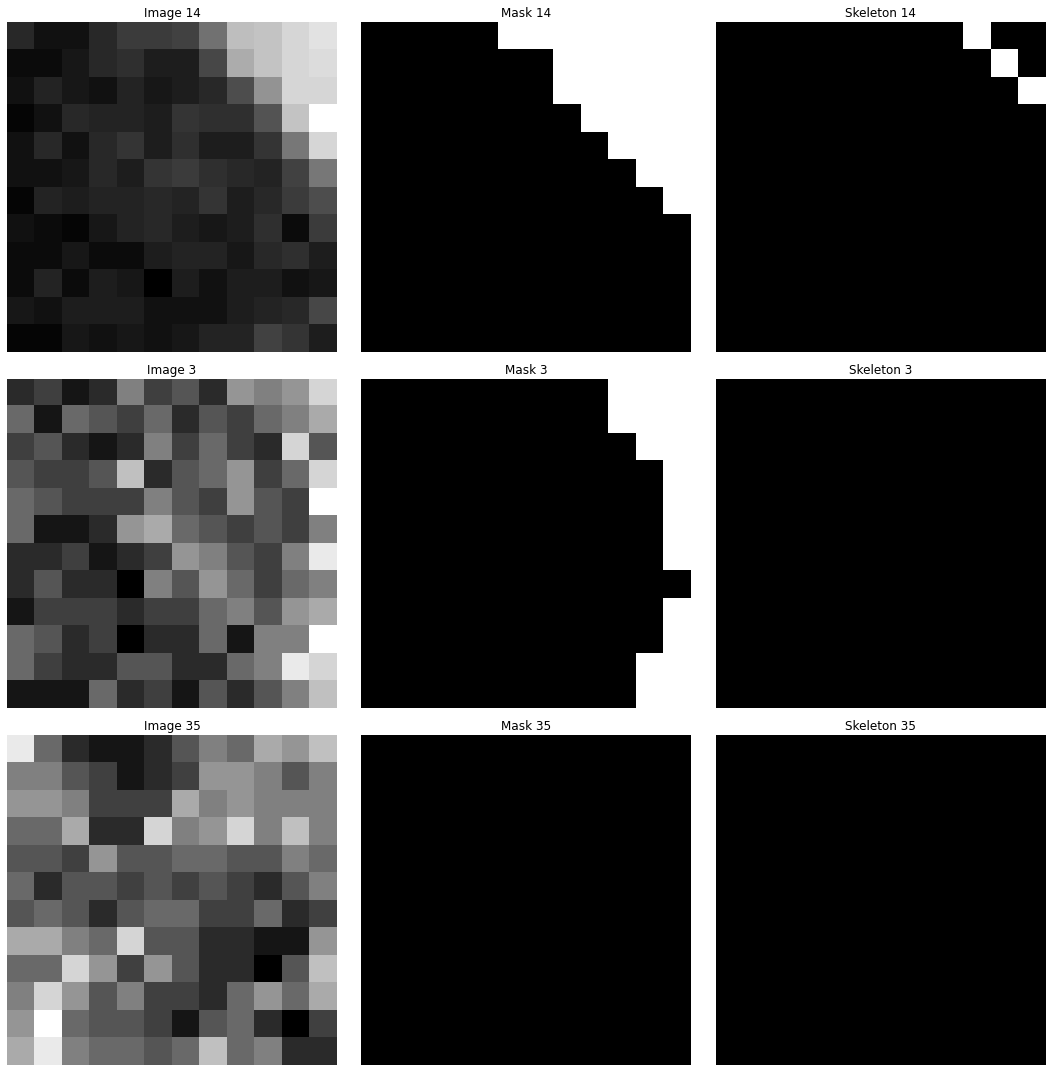

In [312]:
# Training Dataset
image_dir_training = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_training/images'
mask_dir_training = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_training/labels'
skeleton_dir_training = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_training/skeletons'

image_size = 12

# Instantiate the dataset
training_dataset = CustomImageDataset(image_dir_training, mask_dir_training, skeleton_dir_training, image_size)

# Test __len__ method
print("Number of items in the dataset:", len(training_dataset))

# Test __getitem__ method
image, mask, skeleton = training_dataset.__getitem__(0)  # Test with the first item
print("Shapes of the loaded items:", image.shape, mask.shape, skeleton.shape)

# Plot samples using the plot_samples method
training_dataset.plot_samples()  # This will display a figure with random images, masks, and skeletons

Number of items in the dataset: 20
Shapes of the loaded items: torch.Size([1, 12, 12]) torch.Size([1, 12, 12]) torch.Size([1, 12, 12])


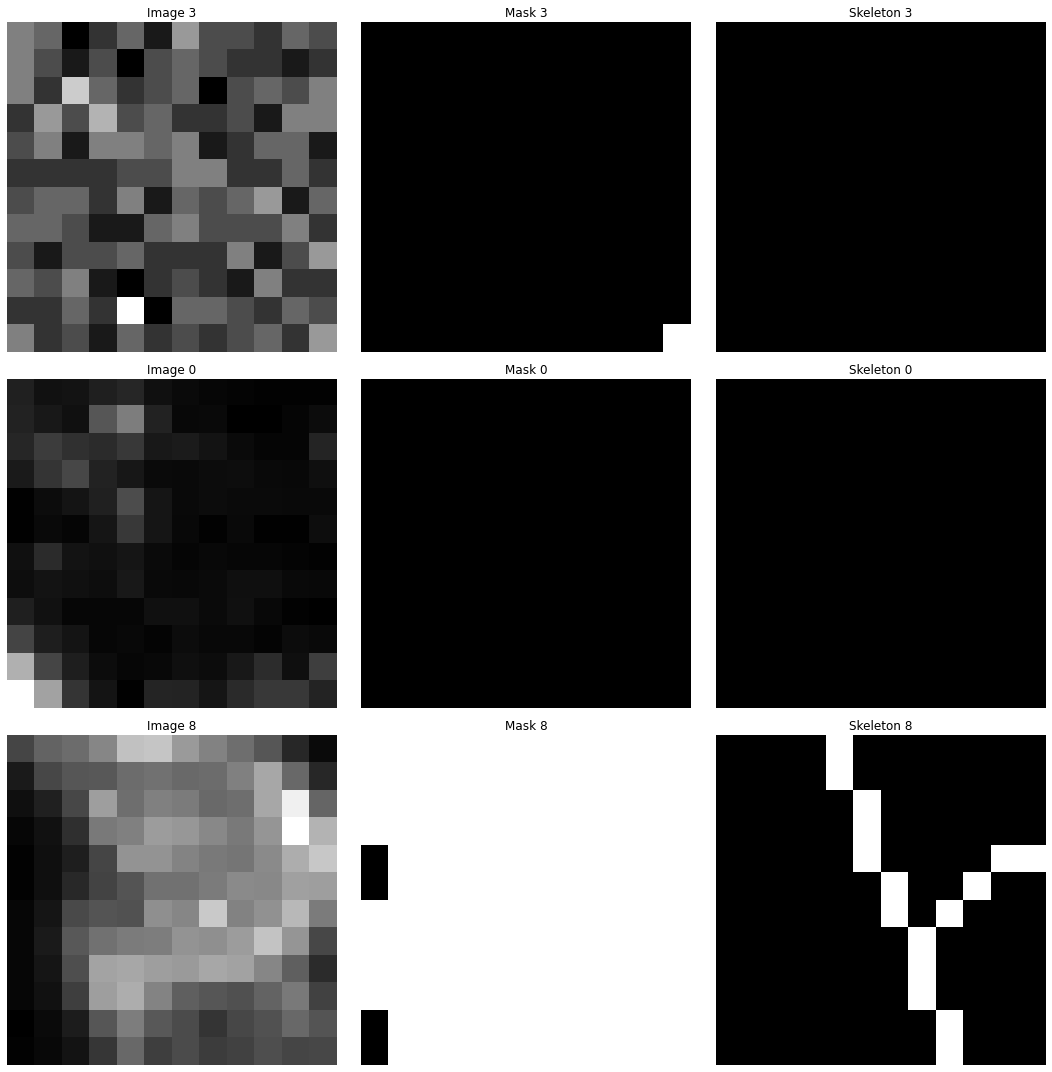

In [313]:
# Validation dataset
image_dir_validation = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_validation/images'
mask_dir_validation = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_validation/labels'
skeleton_dir_validation = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap_gradient_validation/skeletons'

image_size = 12

# Instantiate the dataset
validation_dataset = CustomImageDataset(image_dir_validation, mask_dir_validation, skeleton_dir_validation, image_size)

# Test __len__ method
print("Number of items in the dataset:", len(validation_dataset))

# Test __getitem__ method
image, mask, skeleton = validation_dataset.__getitem__(0)  # Test with the first item
print("Shapes of the loaded items:", image.shape, mask.shape, skeleton.shape)

# Plot samples using the plot_samples method
validation_dataset.plot_samples()  # This will display a figure with random images, masks, and skeletons

In [314]:
# Dataloaders
batch_size = 2

train_loader = DataLoader(training_dataset, 
                          batch_size=batch_size, 
                          shuffle=False)

test_loader = DataLoader(validation_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [315]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [316]:
# Auxiliary Functions
def get_all_gradients(model, image, sampling_rate=1, device="cuda", vectorize=False):

    model.to(device)
    model = model.eval()
    model_wrapped = wrapper(model)
    sampled_image = image[:,::sampling_rate,::sampling_rate]
    sampled_image = sampled_image.to(device).unsqueeze(0)
    sampled_image.requires_grad = True

    jacobian = torch.autograd.functional.jacobian(model_wrapped, 
                                                            sampled_image,
                                                            vectorize = vectorize)
    jacobian = jacobian.squeeze().to('cpu')
    return jacobian

def wrapper(model):
    '''Wrap model to return probabilities and only the vessel channel.'''
    def new_model(img):
        out = model(img)
        probs = F.softmax(out, dim=1)
        return probs[:,1]
    return new_model


def jacobian_activation(jacobian_gradient):  
    dimension = jacobian_gradient.shape[0]
    map = jacobian_gradient.permute(2, 3, 0, 1).reshape(dimension, dimension, dimension*dimension).cuda()
    #avg_activation = torch.mean(map, dim=2).values
    max_activation = torch.max(map, dim=2).values
    
    return max_activation
                    
    """  # Normalizations
    max_value = torch.max(map)
    min_value = torch.min(map)
    
    avg_normalized = (avg_activation - torch.min(avg_activation)) / (torch.max(avg_activation) - torch.min(avg_activation))
    max_normalized = (max_activation - torch.min(max_activation)) / (max_value - torch.min(max_activation))
    

    return avg_activation, max_activation, avg_normalized, max_normalized """

In [317]:
# Training loop
def training_loop(model, train_loader, test_loader, num_epochs, train_losses, test_losses, test_accuracies, test_ious, lr=0.001, weight_decay=1e-4, gradient_optimization=False, optim_idx = 5):
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_iou = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels, _ = data 
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.squeeze(1).long()
            

            outputs = model(inputs)
            
            #print("Output: ", outputs.shape)
            #print("Loss Shape: ", loss.shape)

            if gradient_optimization and (epoch + 1) % optim_idx == 0:
                loss = criterion(outputs, labels)
                
                #print("Loss: ", loss.shape)
                
                non_grad_inputs = inputs.detach()
                """ with torch.no_grad():
                    loss = loss.mean()
                loss.backward(retain_graph=True) """
                for img_idx, input_tensor in enumerate(non_grad_inputs):
                    #print(f"Optimization for image {img_idx} in batch.")
                    model_cp = CustomResNet(num_classes=2).cuda()
                    model_cp.load_state_dict(copy.deepcopy(model.state_dict()))
                    #print("Input: ",input_tensor.shape)
                    jacobian_gradient = get_all_gradients(model_cp,
                                                          input_tensor,
                                                          sampling_rate=1)
                    
                    max_activation = jacobian_activation(jacobian_gradient)
                    #print("Activation: ",max_activation.shape)
                    
                    
                    """ with torch.no_grad():
                        print("Loss Shape: ", loss.shape)
                        print("Jacobian Shape: ", jacobian_gradient.shape)
                        print("Activation Shape: ", max_activation.shape)
                        loss[img_idx, :, :] = (loss[img_idx, :, :] * max_activation).sum() """
                        
                    #print("Loss Shape: ", loss[img_idx].shape)
                    
                    # Integrate max_activation into the loss
                    weighted_loss = (loss[img_idx] * max_activation.squeeze()).mean()
                    running_loss += weighted_loss.detach().item()
                    weighted_loss.backward(retain_graph=True)  # Update gradients based on weighted loss
            else:
                loss = criterion(outputs, labels).mean()
                loss.backward()
                running_loss += loss.detach().item()
                
            optimizer.zero_grad()
            optimizer.step()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        _, predicted = torch.max(outputs.data, 1)
        train_iou += iou_metric(labels.float(), predicted.float())
            
            
        model.eval()
        test_loss = 0.0
        total_iou = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels, _ = data
                images, labels = images.cuda(), labels.cuda()
                labels = labels.squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, labels).mean()
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_iou += iou_metric(labels.float(), predicted.float())

        avg_test_loss = test_loss / len(test_loader)
        avg_iou = total_iou / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_iou.cpu())
        test_ious.append(avg_iou.cpu())

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Train IoU: {train_iou:.4f} Test IoU: {avg_iou:.4f}')


In [318]:
# Gradient optimization model training

# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []
test_ious = []

num_epochs = 14

# Model Initialization
grad_model = CustomResNet(num_classes=2).cuda() 
training_loop(grad_model, 
              train_loader, 
              test_loader, 
              num_epochs, 
              train_losses, 
              test_losses, 
              test_accuracies, 
              test_ious,
              gradient_optimization = True,
              optim_idx = 1)

Epoch [1/14] Train Loss: 0.0506 Test Loss: 0.6929 Train IoU: 0.2800 Test IoU: 0.2492
Epoch [2/14] Train Loss: 0.0203 Test Loss: 0.6935 Train IoU: 0.3716 Test IoU: 0.3032


In [ ]:
# TODO: treinar o modelo normalmente, ver o quando para de diminuir, fazer a ponderacao apenas quando parou de diminuir em uma epoca especifica
        
# TODO: fazer uma analise da curva da loss do modelo normal ao longo do tempo, comparar com a curva da loss normal + x epoca(s) com ponderacao

In [ ]:
# Normal model training 
# Placeholders for metrics
normal_train_losses = []
normal_test_losses = []
normal_test_accuracies = []
normal_test_ious = []

num_epochs = 14

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader, 
              test_loader, 
              num_epochs, 
              normal_train_losses, 
              normal_test_losses, 
              normal_test_accuracies, 
              normal_test_ious,
              gradient_optimization = False)

' # Placeholders for metrics\nnormal_train_losses = []\nnormal_test_losses = []\nnormal_test_accuracies = []\nnormal_test_ious = []\n\nnum_epochs = 6\n\n# Model Initialization\nmodel = CustomResNet(num_classes=2).cuda() \ntraining_loop(model, \n              train_loader, \n              test_loader, \n              num_epochs, \n              normal_train_losses, \n              normal_test_losses, \n              normal_test_accuracies, \n              normal_test_ious,\n              gradient_optimization = False) '